# Constructing an Index-Based Vector Store for Semantic Search with LlamaIndex, ChromaDB and OpenAI

copyright 2024, Denis Rothman

A Practical Guide to Building a Semantic Search Engine with LlamaIndex, ChromaDB and OpenAI:

*   Installing the Environment
*   Creating and populating the Vector Store with ChromaDB
*   Getting started with index-based semantic search
*   Comparing different index types (Vector, Tree, List, Keyword)

# Installing the environment

This notebook uses local environment with `.env` file for API keys.

In [1]:
# Import required modules
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Document
import os
from dotenv import load_dotenv

# Load API keys from .env file
load_dotenv()

# Set API keys
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")

# Verify API keys are loaded
if not os.getenv("OPENAI_API_KEY"):
    raise ValueError("OPENAI_API_KEY not found in .env file")

print("✓ Environment configured")
print(f"  OpenAI API Key: {os.getenv('OPENAI_API_KEY')[:10]}...")

c:\Users\user\Desktop\RAG-Driven-Generative-AI\.venv\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'validate_default' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'validate_default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(


✓ Environment configured
  OpenAI API Key: sk-proj-lq...


Next, let's import the required modules and set the needed environmental variables:

In [2]:
# Import LlamaIndex and ChromaDB modules
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Document, StorageContext
from llama_index.vector_stores.chroma import ChromaVectorStore
import chromadb

In [3]:
# Load OpenAI API key from environment
import openai
openai.api_key = os.getenv("OPENAI_API_KEY")

**Note:** This notebook uses ChromaDB with LlamaIndex. Make sure you have the required package:
```bash
uv pip install llama-index-vector-stores-chroma
```

# Pipeline 1 : Collecting and preparing the documents

In [4]:
import os
import shutil

# Recreate data directory (delete if exists, then create fresh)
if os.path.exists("data"):
    shutil.rmtree("data")
    print("✓ Deleted existing data directory")

os.makedirs("data", exist_ok=True)
print("✓ Created fresh data directory")

✓ Deleted existing data directory
✓ Created fresh data directory


In [5]:
import requests
from bs4 import BeautifulSoup
import re
import os

# URLs for drone and computer vision content
urls = [
    "https://github.com/VisDrone/VisDrone-Dataset",
    "https://paperswithcode.com/dataset/visdrone",
    "https://openaccess.thecvf.com/content_ECCVW_2018/papers/11133/Zhu_VisDrone-DET2018_The_Vision_Meets_Drone_Object_Detection_in_Image_Challenge_ECCVW_2018_paper.pdf",
    "https://github.com/VisDrone/VisDrone2018-MOT-toolkit",
    "https://en.wikipedia.org/wiki/Object_detection",
    "https://en.wikipedia.org/wiki/Computer_vision",
    "https://en.wikipedia.org/wiki/Convolutional_neural_network",
    "https://en.wikipedia.org/wiki/Unmanned_aerial_vehicle",
    "https://www.faa.gov/uas/",
    "https://www.tensorflow.org/",
    "https://pytorch.org/",
    "https://keras.io/",
    "https://arxiv.org/abs/1804.06985",
    "https://arxiv.org/abs/2202.11983",
    "https://motchallenge.net/",
    "http://www.cvlibs.net/datasets/kitti/",
    "https://www.dronedeploy.com/",
    "https://www.dji.com/",
    "https://arxiv.org/",
    "https://openaccess.thecvf.com/",
    "https://roboflow.com/",
    "https://www.kaggle.com/",
    "https://paperswithcode.com/",
    "https://github.com/"
]

print(f"✓ Loaded {len(urls)} URLs to process")

✓ Loaded 24 URLs to process


## Helper Functions for Text Cleaning and PDF Extraction

The following functions help clean and validate extracted text, including PDF support.

In [6]:
from io import BytesIO
try:
    from PyPDF2 import PdfReader
    PDF_SUPPORT = True
except ImportError:
    PDF_SUPPORT = False
    print("⚠ PyPDF2 not found. PDF extraction will be skipped.")
    print("  Install with: uv pip install PyPDF2")

def clean_text(content):
    """Remove references and clean up text."""
    content = re.sub(r'\[\d+\]', '', content)  # Remove references like [1], [2]
    return content

def extract_text_from_pdf(pdf_content):
    """Extract text from PDF bytes."""
    if not PDF_SUPPORT:
        return None
    
    try:
        pdf_file = BytesIO(pdf_content)
        pdf_reader = PdfReader(pdf_file)
        
        text_parts = []
        for page in pdf_reader.pages:
            text = page.extract_text()
            if text:
                text_parts.append(text)
        
        if text_parts:
            full_text = ' '.join(text_parts)
            return clean_text(full_text)
        else:
            return None
            
    except Exception as e:
        print(f"  PDF extraction error: {e}")
        return None

def is_valid_paragraph(p, min_length=20):
    """Check if paragraph is meaningful and not in excluded sections."""
    text = p.get_text(strip=True)
    if len(text) < min_length:
        return False
    
    # Check parent classes for excluded sections
    parent_classes = []
    for parent in p.parents:
        if parent.get('class'):
            parent_classes.extend(parent.get('class'))
    
    # Skip reference/navigation sections
    skip_classes = ['references', 'reflist', 'navbox', 'metadata', 'ambox', 'infobox']
    parent_class_string = ' '.join(parent_classes).lower()
    if any(skip_class in parent_class_string for skip_class in skip_classes):
        return False
    
    # Check if we're past References heading
    prev_headings = p.find_all_previous(['h2', 'h3'], limit=1)
    if prev_headings:
        heading_text = prev_headings[0].get_text().strip().lower()
        excluded_sections = ['references', 'bibliography', 'external links', 
                            'see also', 'notes', 'citations']
        if any(section in heading_text for section in excluded_sections):
            return False
    
    return True

print("✓ Text cleaning and PDF extraction functions defined")
if PDF_SUPPORT:
    print("  PDF support: enabled")
else:
    print("  PDF support: disabled (PyPDF2 not installed)")

✓ Text cleaning and PDF extraction functions defined
  PDF support: enabled


## Wikipedia Content Extractor

Specialized function for extracting clean content from Wikipedia articles. It filters out navigation, infoboxes, and reference sections.

In [7]:
def extract_wikipedia_content(soup):
    """Extract content from Wikipedia articles."""
    content = soup.find('div', class_='mw-parser-output')
    if content is None:
        return None
    
    all_paragraphs = soup.find_all('p')
    content_paragraphs = [p for p in all_paragraphs 
                          if p.find_parent('div', class_='mw-parser-output') is not None]
    
    if not content_paragraphs:
        print(f"  Warning: No paragraphs found in Wikipedia content area")
        return None
    
    # Filter valid paragraphs
    filtered_paragraphs = [p for p in content_paragraphs if is_valid_paragraph(p)]
    
    if not filtered_paragraphs:
        print(f"  Warning: All paragraphs filtered out")
        return None
    
    text = ' '.join([p.get_text(strip=True) for p in filtered_paragraphs])
    return clean_text(text)

print("✓ Wikipedia extractor defined")

✓ Wikipedia extractor defined


## Generic Content Extractor

Handles non-Wikipedia pages like GitHub, ArXiv, and other technical documentation sites.

In [8]:
def extract_generic_content(soup):
    """Extract content from non-Wikipedia pages."""
    # Remove unwanted elements
    for element in soup(["script", "style", "nav", "footer", "header"]):
        element.decompose()
    
    # Try to find main content area
    content_selectors = [
        {'id': 'content'},
        {'class': 'content'},
        {'class': 'main-content'},
        {'id': 'main'},
        {'class': 'article'},
        {'role': 'main'},
        {'class': 'markdown-body'},  # GitHub
        {'class': 'abstract'},  # ArXiv
    ]
    
    main_content = None
    for selector in content_selectors:
        for tag in ['div', 'main', 'article']:
            main_content = soup.find(tag, selector)
            if main_content:
                break
        if main_content:
            break
    
    # Extract paragraphs
    if main_content:
        paragraphs = main_content.find_all('p')
    else:
        paragraphs = soup.find_all('p')
    
    # Get text from paragraphs or fallback to all text
    if paragraphs:
        valid_paragraphs = [p.get_text(strip=True) for p in paragraphs 
                           if len(p.get_text(strip=True)) > 20]
        text = ' '.join(valid_paragraphs)
    else:
        text = soup.get_text(separator=' ', strip=True)
    
    return clean_text(text) if text else None

print("✓ Generic content extractor defined")

✓ Generic content extractor defined


## Main Fetch and Clean Function

Orchestrates the fetching and extraction process with intelligent content type detection:

1. **PDF Detection**: Checks Content-Type header and file extension
2. **PDF Extraction**: Uses PyPDF2 to extract text from PDF files
3. **HTML Parsing**: Falls back to Wikipedia or generic extraction for web pages

This modular design allows easy extension for other file types (DOCX, TXT, etc.).

In [9]:
def fetch_and_clean(url):
    """
    Fetch and extract clean text from a URL.
    Supports Wikipedia, GitHub, ArXiv, PDF files, and generic web pages.
    """
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        # Check if content is PDF
        content_type = response.headers.get('Content-Type', '').lower()
        is_pdf = 'application/pdf' in content_type or url.lower().endswith('.pdf')
        
        if is_pdf:
            print(f"  Detected PDF file")
            text = extract_text_from_pdf(response.content)
            if text:
                return text
            else:
                print(f"  Warning: Could not extract text from PDF")
                return ""
        
        # Not a PDF - parse as HTML
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Try Wikipedia-specific extraction first
        text = extract_wikipedia_content(soup)
        
        # If not Wikipedia or extraction failed, try generic extraction
        if text is None:
            text = extract_generic_content(soup)
        
        if not text:
            print(f"  Warning: Could not extract content")
            return ""
        
        return text
        
    except requests.exceptions.RequestException as e:
        print(f"  Error fetching: {e}")
        return ""
    except Exception as e:
        print(f"  Unexpected error: {e}")
        import traceback
        traceback.print_exc()
        return ""

print("✓ Main fetch_and_clean function defined (with PDF support)")

✓ Main fetch_and_clean function defined (with PDF support)


## Filename Utility

Creates safe filenames from URLs by removing special characters and handling edge cases.

In [10]:
def create_safe_filename(url, index):
    """Create a safe filename from URL."""
    article_name = url.split('/')[-1]
    article_name = article_name.replace('.pdf', '').replace('.html', '').replace('_', ' ')
    
    # Handle empty names
    if not article_name or article_name.strip() == '':
        article_name = f"article_{index}"
    
    # Create safe filename
    safe_filename = re.sub(r'[^\w\s-]', '', article_name).strip().replace(' ', '_')
    if not safe_filename:
        safe_filename = f"article_{index}"
    
    return safe_filename

print("✓ Filename utility defined")

✓ Filename utility defined


## Process All URLs

Iterate through all URLs, fetch content, and save each to a separate text file in the `./data/` directory.

In [11]:
# Directory to store the output files
output_dir = './data/'
os.makedirs(output_dir, exist_ok=True)

# Process each URL and save to separate files
successful = 0
skipped = 0

for i, url in enumerate(urls, 1):
    article_name = url.split('/')[-1].replace('.pdf', '').replace('.html', '').replace('_', ' ')
    if not article_name or article_name.strip() == '':
        article_name = f"article_{i}"
    
    safe_filename = create_safe_filename(url, i)
    filename = os.path.join(output_dir, f"{safe_filename}.txt")
    
    print(f"\nProcessing {i}/{len(urls)}: {article_name}")
    clean_article_text = fetch_and_clean(url)
    
    if clean_article_text and len(clean_article_text) > 100:
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(clean_article_text)
        print(f"  ✓ Success: {len(clean_article_text):,} characters extracted")
        print(f"  Saved to: {filename}")
        successful += 1
    else:
        print(f"  ✗ Skipped: Insufficient content")
        skipped += 1

print(f"\n{'='*60}")
print(f"Complete: {successful} articles saved, {skipped} skipped")
print(f"Success rate: {successful/len(urls)*100:.1f}%")
print(f"Files saved in {output_dir} directory")


Processing 1/24: VisDrone-Dataset
  ✓ Success: 3,541 characters extracted
  Saved to: ./data/VisDrone-Dataset.txt

Processing 2/24: visdrone
  ✓ Success: 132,618 characters extracted
  Saved to: ./data/visdrone.txt

Processing 3/24: Zhu VisDrone-DET2018 The Vision Meets Drone Object Detection in Image Challenge ECCVW 2018 paper
  Detected PDF file
  ✓ Success: 77,120 characters extracted
  Saved to: ./data/Zhu_VisDrone-DET2018_The_Vision_Meets_Drone_Object_Detection_in_Image_Challenge_ECCVW_2018_paper.txt

Processing 4/24: VisDrone2018-MOT-toolkit
  ✓ Success: 2,393 characters extracted
  Saved to: ./data/VisDrone2018-MOT-toolkit.txt

Processing 5/24: Object detection
  ✓ Success: 3,703 characters extracted
  Saved to: ./data/Object_detection.txt

Processing 6/24: Computer vision
  ✓ Success: 24,225 characters extracted
  Saved to: ./data/Computer_vision.txt

Processing 7/24: Convolutional neural network
  ✓ Success: 52,501 characters extracted
  Saved to: ./data/Convolutional_neural_

In [12]:
# load documents
documents = SimpleDirectoryReader("./data/").load_data()

In [13]:
documents[10]

Document(id_='76009302-9387-4f8e-bbc6-6cc25cda2462', embedding=None, metadata={'file_path': 'c:\\Users\\user\\Desktop\\RAG-Driven-Generative-AI\\Chapter03\\data\\article_21.txt', 'file_name': 'article_21.txt', 'file_type': 'text/plain', 'file_size': 2244, 'creation_date': '2025-10-30', 'last_modified_date': '2025-10-30'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='RF-DETR: DINOv2 pretrained encoder + multiscale DETR architecture = SOTA on fast object detection.[DETR whisperer @nicolas.carion] the right UX is key! Love how Roboflow has adapted SAM/SAM2 interface to maximize utility and efficiency! Software is eating the world but it st

# Pipeline 2 : Creating and populating a ChromaDB Vector Store with LlamaIndex

**Local vector store using ChromaDB - no cloud dependencies required**

In [14]:
import chromadb
from llama_index.core import StorageContext
from llama_index.vector_stores.chroma import ChromaVectorStore

# Configuration
CHROMA_PATH = "./chroma_db"
COLLECTION_NAME = "drone_vision"

# Initialize ChromaDB client
chroma_client = chromadb.PersistentClient(path=CHROMA_PATH)

# Delete existing collection and create fresh one
try:
    chroma_client.delete_collection(name=COLLECTION_NAME)
    print(f"✓ Deleted existing collection: {COLLECTION_NAME}")
except:
    print(f"  No existing collection to delete")

# Create fresh collection
chroma_collection = chroma_client.create_collection(name=COLLECTION_NAME)

# Create ChromaVectorStore
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

# Create storage context
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# Create an index over the documents
print(f"Creating index with {len(documents)} documents...")
index = VectorStoreIndex.from_documents(
    documents, 
    storage_context=storage_context,
    show_progress=True
)

print(f"✓ Index created successfully")
print(f"  Collection: {COLLECTION_NAME}")
print(f"  Storage path: {CHROMA_PATH}")
print(f"  Total documents: {len(documents)}")

✓ Deleted existing collection: drone_vision
Creating index with 22 documents...


c:\Users\user\Desktop\RAG-Driven-Generative-AI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating embeddings: 100%|██████████| 150/150 [00:07<00:00, 20.62it/s]


✓ Index created successfully
  Collection: drone_vision
  Storage path: ./chroma_db
  Total documents: 22


In [15]:
# Verify the collection
collection_count = chroma_collection.count()
print(f"✓ ChromaDB collection verified")
print(f"  Total items in collection: {collection_count}")

✓ ChromaDB collection verified
  Total items in collection: 150


In [16]:
# Function to display a selected record from ChromaDB
def display_record(record_number):
    # Get all data from the collection
    results = chroma_collection.get(
        include=["documents", "metadatas", "embeddings"]
    )
    
    if record_number >= len(results['ids']):
        print(f"Error: Record number {record_number} out of range. Collection has {len(results['ids'])} items.")
        return
    
    # Extract the specific record
    record_id = results['ids'][record_number]
    document = results['documents'][record_number]
    metadata = results['metadatas'][record_number]
    embedding = results['embeddings'][record_number]
    
    # Print the ID
    print("ID:")
    print(record_id)
    print()
    
    # Print the metadata in a structured format
    print("Metadata:")
    for key, value in metadata.items():
        print(f"  {key}: {value}")
    print()
    
    # Print the text (truncated for readability)
    print("Text:")
    print(document[:500] + "..." if len(document) > 500 else document)
    print()
    
    # Print the embedding (first 10 values for readability)
    print("Embedding (first 10 values):")
    print(embedding[:10])
    print(f"  ... (total {len(embedding)} dimensions)")
    print()



# Function call to display a record
rec = 40  # Replace with the desired record number
display_record(rec)

ID:
aa573579-ad0a-48a1-a87e-00b453ca54ab

Metadata:
  document_id: 8cab4fde-5bd7-480c-ba33-1c32f49b1cef
  ref_doc_id: 8cab4fde-5bd7-480c-ba33-1c32f49b1cef
  file_path: c:\Users\user\Desktop\RAG-Driven-Generative-AI\Chapter03\data\article_23.txt
  file_size: 134314
  _node_content: {"id_": "aa573579-ad0a-48a1-a87e-00b453ca54ab", "embedding": null, "metadata": {"file_path": "c:\\Users\\user\\Desktop\\RAG-Driven-Generative-AI\\Chapter03\\data\\article_23.txt", "file_name": "article_23.txt", "file_type": "text/plain", "file_size": 134314, "creation_date": "2025-10-30", "last_modified_date": "2025-10-30"}, "excluded_embed_metadata_keys": ["file_name", "file_type", "file_size", "creation_date", "last_modified_date", "last_accessed_date"], "excluded_llm_metadata_keys": ["file_name", "file_type", "file_size", "creation_date", "last_modified_date", "last_accessed_date"], "relationships": {"1": {"node_id": "8cab4fde-5bd7-480c-ba33-1c32f49b1cef", "node_type": "4", "metadata": {"file_path": "c:\\U

In [17]:
# The documents are already loaded from files in cell-22
# They're now stored in ChromaDB and ready for index-based retrieval
print(f"✓ Documents ready for index comparison")
print(f"  Total documents: {len(documents)}")
print(f"  Total chunks in ChromaDB: {collection_count}")

✓ Documents ready for index comparison
  Total documents: 22
  Total chunks in ChromaDB: 150


# Pipeline 3: Index-based RAG with LlamaIndex

Now we'll compare different LlamaIndex index types using the documents loaded from local files.

In [18]:
# User input and RAG parameters
user_input="How do drones identify vehicles?"

#similarity_top_k
k=3
#temperature
temp=0.1
#num_output
mt=1024

# Initialize results dictionary to collect metrics from all index types
index_results = {}

## User Input and RAG Parameters

## Cosine similarity metric

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

def calculate_cosine_similarity_with_embeddings(text1, text2):
    embeddings1 = model.encode(text1)
    embeddings2 = model.encode(text2)
    similarity = cosine_similarity([embeddings1], [embeddings2])
    return similarity[0][0]

# Vector store index query engine

In [21]:
from llama_index.core import VectorStoreIndex
vector_store_index = VectorStoreIndex.from_documents(documents)

In [22]:
print(type(vector_store_index))

<class 'llama_index.core.indices.vector_store.base.VectorStoreIndex'>


In [23]:
vector_query_engine = vector_store_index.as_query_engine(similarity_top_k=k, temperature=temp, num_output=mt)

In [24]:
print(type(vector_query_engine))

<class 'llama_index.core.query_engine.retriever_query_engine.RetrieverQueryEngine'>


## Query response and source

In [25]:
import pandas as pd
import textwrap

def index_query(input_query):
    response = vector_query_engine.query(input_query)

    # Optional: Print a formatted view of the response (remove if you don't need it in the output)
    print(textwrap.fill(str(response), 100))

    node_data = []
    for node_with_score in response.source_nodes:
        node = node_with_score.node
        node_info = {
            'Node ID': node.id_,
            'Score': node_with_score.score,
            'Text': node.text
        }
        node_data.append(node_info)

    df = pd.DataFrame(node_data)

    # Instead of printing, return the DataFrame and the response object
    return df, response


In [26]:
import time
#start the timer
start_time = time.time()
df, response = index_query(user_input)
# Stop the timer
end_time = time.time()
# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Query execution time: {elapsed_time:.4f} seconds")

print(df.to_markdown(index=False, numalign="left", stralign="left"))  # Display the DataFrame using markdown

Drones can automatically track and detect vehicles using commercial cameras with the help of deep
learning based machine learning algorithms. Additionally, drones can automatically identify vehicles
across different cameras with different viewpoints and hardware specifications using re-
identification methods.
Query execution time: 5.4781 seconds
| Node ID                              | Score    | Text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

Node information and relationships

In [27]:
nodeid=response.source_nodes[0].node_id
nodeid

'27e5a084-9c52-4ca0-b027-d996e944d43f'

In [28]:
response.source_nodes[0].get_text()

'UAVs may help in the discovery of new or reevaluation of knownmineral depositsto meet the demand forraw materialssuch as critical raw metals (e.g.cobalt,nickel),rare earthsand battery minerals. By employing a suite of sensors (e.g.spectral imaging,Lidar,magnetics,gamma-ray spectroscopy),and similar to those used in environmental monitoring, UAV-based data can produce maps of geological surface and subsurface features, contributing to more efficient and targeted mineral exploration. As global demand for food production grows exponentially, resources are depleted, farmland is reduced, and agricultural labor is increasingly in short supply, there is an urgent need for more convenient and smarter agricultural solutions than traditional methods, and the agricultural drone and robotics industry is expected to make progress.Agricultural drones have been used to help build sustainable agriculture all over the world leading to a new generation of agriculture.In this context, there is a prolife

## Optimized chunking

In [29]:
# Assuming you have the 'response' object from query_engine.query()

for node_with_score in response.source_nodes:
    node = node_with_score.node  # Extract the Node object from NodeWithScore
    chunk_size = len(node.text)
    print(f"Node ID: {node.id_}, Chunk Size: {chunk_size} characters")

Node ID: 27e5a084-9c52-4ca0-b027-d996e944d43f, Chunk Size: 4917 characters
Node ID: e532418d-7891-48b3-a449-7c8a81a08f6e, Chunk Size: 4164 characters
Node ID: 47a0b8ed-9dbf-4e32-9dd9-695ea308ce0e, Chunk Size: 4414 characters


## Performance metric

In [30]:
import numpy as np

def info_metrics(response):
  # Calculate the performance (handling None scores)
  scores = [node.score for node in response.source_nodes if node.score is not None]
  if scores:  # Check if there are any valid scores
      weights = np.exp(scores) / np.sum(np.exp(scores))
      perf = np.average(scores, weights=weights) / elapsed_time
  else:
      perf = 0  # Or some other default value if all scores are None

  average_score=np.average(scores, weights=weights)
  print(f"Average score: {average_score:.4f}")
  print(f"Query execution time: {elapsed_time:.4f} seconds")
  print(f"Performance metric: {perf:.4f}")

In [31]:
info_metrics(response)

# Store Vector Store Index results
index_results['Vector Store'] = {
    'query_time': elapsed_time,
    'average_score': np.average([node.score for node in response.source_nodes if node.score is not None],
                                weights=np.exp([node.score for node in response.source_nodes if node.score is not None]) / 
                                np.sum(np.exp([node.score for node in response.source_nodes if node.score is not None]))),
    'response_text': str(response),
    'index_class': 'VectorStoreIndex'
}

Average score: 0.8331
Query execution time: 5.4781 seconds
Performance metric: 0.1521


# Tree index query engine

In [32]:
from llama_index.core import TreeIndex
tree_index = TreeIndex.from_documents(documents)

In [33]:
print(type(tree_index))

<class 'llama_index.core.indices.tree.base.TreeIndex'>


In [34]:
tree_query_engine = tree_index.as_query_engine(similarity_top_k=k, temperature=temp, num_output=mt)

In [35]:
import time
import textwrap
# Start the timer
start_time = time.time()
response = tree_query_engine.query(user_input)
# Stop the timer
end_time = time.time()
# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Query execution time: {elapsed_time:.4f} seconds")

print(textwrap.fill(str(response), 100))

Query execution time: 5.5332 seconds
Drones identify vehicles using object detection methods based on deep Convolutional Neural Networks
(CNN). These methods involve generating object proposals and predicting accurate object regions and
corresponding class labels using CNN models trained on large datasets like ImageNet. The process
typically includes extracting features, classifying object proposals, and refining spatial locations
in an end-to-end manner.


## Performance metric

In [36]:
similarity_score = calculate_cosine_similarity_with_embeddings(user_input, str(response))
print(f"Cosine Similarity Score: {similarity_score:.3f}")
print(f"Query execution time: {elapsed_time:.4f} seconds")
performance=similarity_score/elapsed_time
print(f"Performance metric: {performance:.4f}")

# Store Tree Index results
index_results['Tree'] = {
    'query_time': elapsed_time,
    'cosine_similarity': similarity_score,
    'performance_metric': performance,
    'response_text': str(response),
    'index_class': 'TreeIndex'
}

Cosine Similarity Score: 0.710
Query execution time: 5.5332 seconds
Performance metric: 0.1283


# List index query engine

In [37]:
from llama_index.core import ListIndex
list_index = ListIndex.from_documents(documents)

In [38]:
print(type(list_index))

<class 'llama_index.core.indices.list.base.SummaryIndex'>


In [39]:
list_query_engine = list_index.as_query_engine(similarity_top_k=k, temperature=temp, num_output=mt)

In [40]:
#start the timer
start_time = time.time()
response = list_query_engine.query(user_input)
# Stop the timer
end_time = time.time()
# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Query execution time: {elapsed_time:.4f} seconds")

print(textwrap.fill(str(response), 100))

Query execution time: 25.6438 seconds
Drones do not identify vehicles in the provided context information.


## Performance metric

In [41]:
similarity_score = calculate_cosine_similarity_with_embeddings(user_input, str(response))
print(f"Cosine Similarity Score: {similarity_score:.3f}")
print(f"Query execution time: {elapsed_time:.4f} seconds")
performance=similarity_score/elapsed_time
print(f"Performance metric: {performance:.4f}")

# Store List Index results
index_results['List'] = {
    'query_time': elapsed_time,
    'cosine_similarity': similarity_score,
    'performance_metric': performance,
    'response_text': str(response),
    'index_class': 'SummaryIndex'
}

Cosine Similarity Score: 0.623
Query execution time: 25.6438 seconds
Performance metric: 0.0243


# Keyword index query index

In [42]:
from llama_index.core import KeywordTableIndex
keyword_index = KeywordTableIndex.from_documents(documents)

In [43]:
# Extract data for DataFrame
data = []
for keyword, doc_ids in keyword_index.index_struct.table.items():
    for doc_id in doc_ids:
        data.append({"Keyword": keyword, "Document ID": doc_id})

# Create the DataFrame
df = pd.DataFrame(data)
df

,Keyword,Document ID
0,share,40a11e77-95dc-4bdb-ba1a-e5cfd5c6e6d6
1,share,2a64378c-c2ac-48ac-a473-1b6b36791a5b
2,develop,40a11e77-95dc-4bdb-ba1a-e5cfd5c6e6d6
3,develop,2a64378c-c2ac-48ac-a473-1b6b36791a5b
4,website,40a11e77-95dc-4bdb-ba1a-e5cfd5c6e6d6
...,...,...
8111,inception-resnet,a4bdfc8b-29ba-4e23-a813-ab7e011a4b74
8112,boosted cascade,a4bdfc8b-29ba-4e23-a813-ab7e011a4b74
8113,boosted,a4bdfc8b-29ba-4e23-a813-ab7e011a4b74
8114,selective search,a4bdfc8b-29ba-4e23-a813-ab7e011a4b74


In [44]:
keyword_query_engine = keyword_index.as_query_engine(similarity_top_k=k, temperature=temp, num_output=mt)

In [45]:
import time

# Start the timer
start_time = time.time()

# Execute the query (using .query() method)
response = keyword_query_engine.query(user_input)

# Stop the timer
end_time = time.time()

# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Query execution time: {elapsed_time:.4f} seconds")

print(textwrap.fill(str(response), 100))

Query execution time: 2.3634 seconds
Drones identify vehicles through object detection techniques, where algorithms are used to detect
predefined categories of objects such as cars, vans, buses, and trucks in images captured by drones.
These algorithms predict bounding boxes of objects in specific classes with a real-valued
confidence, enabling drones to recognize and differentiate vehicles from other objects in their
surroundings.


## Performance metric

In [46]:
similarity_score = calculate_cosine_similarity_with_embeddings(user_input, str(response))
print(f"Cosine Similarity Score: {similarity_score:.3f}")
print(f"Query execution time: {elapsed_time:.4f} seconds")
performance=similarity_score/elapsed_time
print(f"Performance metric: {performance:.4f}")

# Store Keyword Table Index results
index_results['Keyword Table'] = {
    'query_time': elapsed_time,
    'cosine_similarity': similarity_score,
    'performance_metric': performance,
    'response_text': str(response),
    'index_class': 'KeywordTableIndex'
}

Cosine Similarity Score: 0.762
Query execution time: 2.3634 seconds
Performance metric: 0.3223


# Comprehensive Index Comparison

Summary of all four indexing strategies with performance metrics and visualizations.

In [47]:
# Build comparison DataFrame from collected results
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Check if we have results from all indexes
if len(index_results) < 4:
    print("⚠ Warning: Not all index results are available yet.")
    print(f"  Found: {list(index_results.keys())}")
    print("  Please run all four index query sections above first.")
else:
    # Build DataFrame dynamically from collected results
    comparison_data = []
    
    for index_name, metrics in index_results.items():
        row = {
            'Index Type': index_name,
            'Query Time (s)': metrics.get('query_time', 0),
            'Index Class': metrics.get('index_class', 'Unknown')
        }
        
        # Handle Vector Store (uses average_score) vs others (use cosine_similarity)
        if 'cosine_similarity' in metrics:
            row['Cosine Similarity'] = metrics['cosine_similarity']
            row['Performance Metric'] = metrics['performance_metric']
        elif 'average_score' in metrics:
            # For Vector Store, calculate cosine similarity
            similarity = calculate_cosine_similarity_with_embeddings(
                user_input, 
                metrics['response_text']
            )
            row['Cosine Similarity'] = similarity
            row['Performance Metric'] = similarity / metrics['query_time']
        
        comparison_data.append(row)
    
    # Create DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    
    # Calculate rankings
    comparison_df['Speed Rank'] = comparison_df['Query Time (s)'].rank()
    comparison_df['Quality Rank'] = comparison_df['Cosine Similarity'].rank(ascending=False)
    comparison_df['Overall Rank'] = comparison_df['Performance Metric'].rank(ascending=False)
    
    # Display the comparison table
    print("="*80)
    print("INDEX COMPARISON TABLE (Automatically Generated)")
    print("="*80)
    print(comparison_df.to_string(index=False))
    print("="*80)
    print(f"\nQuery: '{user_input}'")
    print(f"Total indexes compared: {len(comparison_df)}")
    print("="*80)

INDEX COMPARISON TABLE (Automatically Generated)
   Index Type  Query Time (s)       Index Class  Cosine Similarity  Performance Metric  Speed Rank  Quality Rank  Overall Rank
 Vector Store        5.478056  VectorStoreIndex           0.715942            0.130693         2.0           2.0           2.0
         Tree        5.533188         TreeIndex           0.709957            0.128309         3.0           3.0           3.0
         List       25.643807      SummaryIndex           0.623335            0.024307         4.0           4.0           4.0
Keyword Table        2.363428 KeywordTableIndex           0.761717            0.322293         1.0           1.0           1.0

Query: 'How do drones identify vehicles?'
Total indexes compared: 4


## Visualization: Performance Metrics Comparison

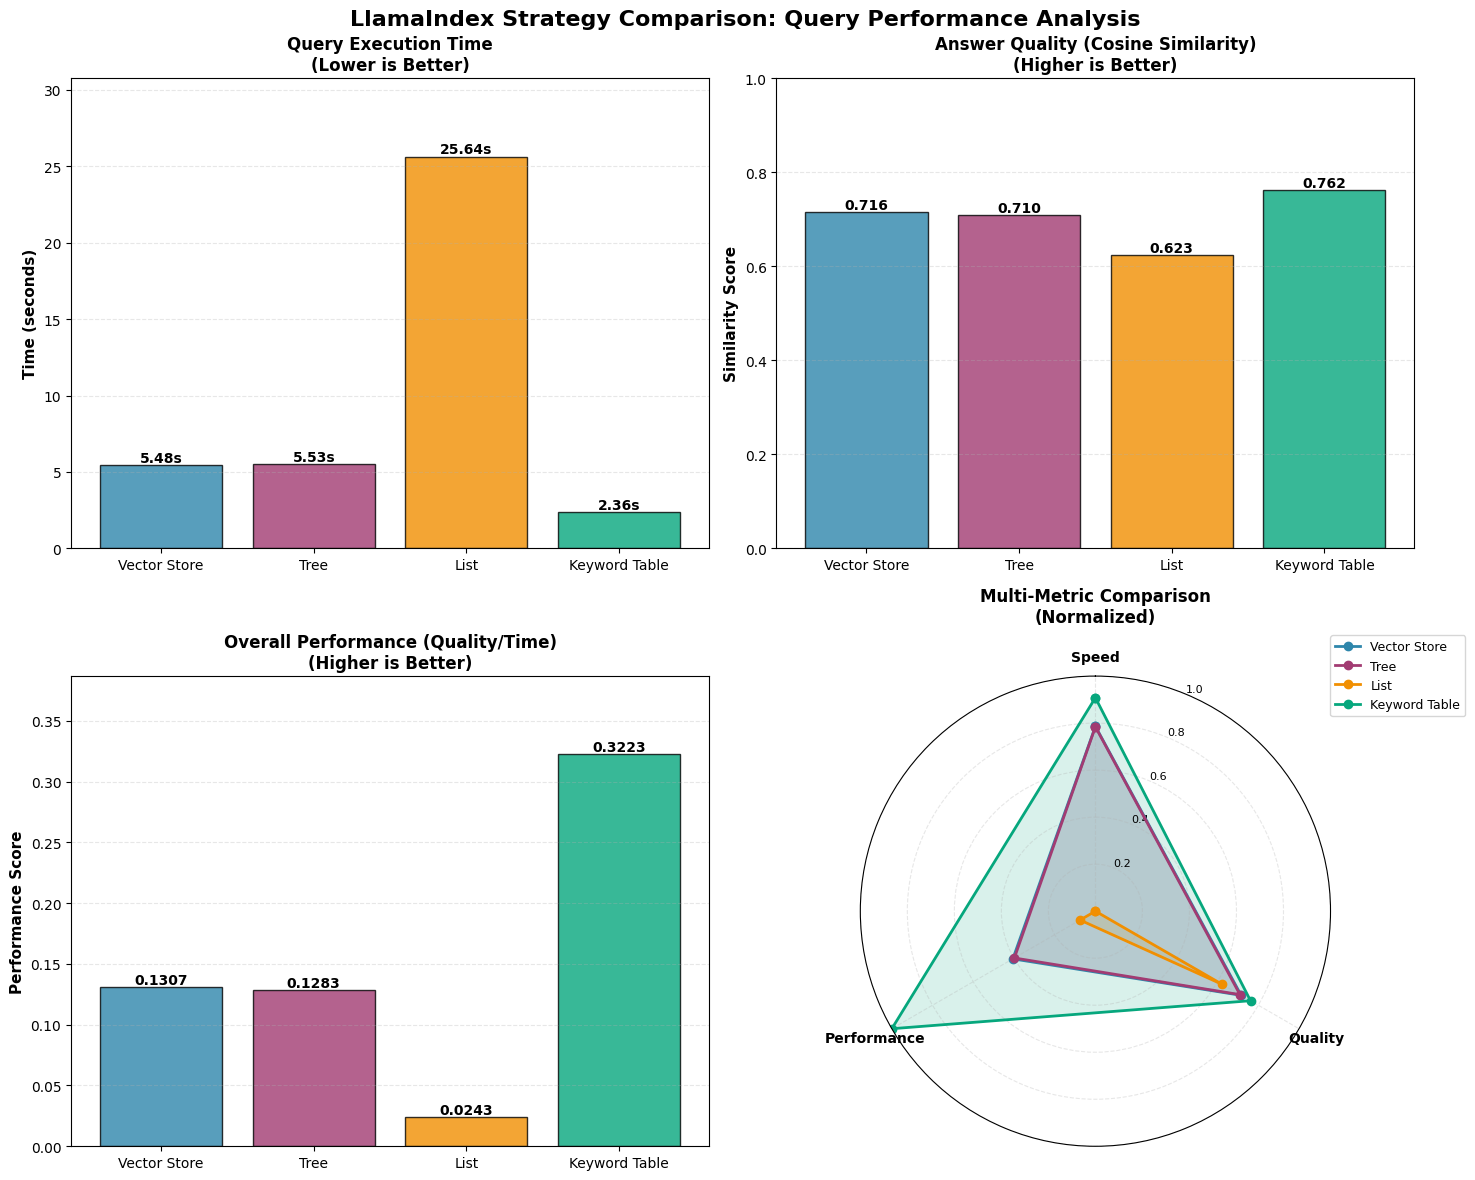


✓ Visualization saved as 'index_comparison.png'


In [48]:
# Create comprehensive visualization (only if all data is available)
if len(index_results) < 4:
    print("⚠ Skipping visualization - not all index results available yet")
else:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('LlamaIndex Strategy Comparison: Query Performance Analysis', fontsize=16, fontweight='bold')

    # Color palette
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#06A77D']
    index_types = comparison_df['Index Type']

    # 1. Query Time Comparison (Bar Chart)
    ax1 = axes[0, 0]
    bars1 = ax1.bar(index_types, comparison_df['Query Time (s)'], color=colors, alpha=0.8, edgecolor='black')
    ax1.set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
    ax1.set_title('Query Execution Time\n(Lower is Better)', fontsize=12, fontweight='bold')
    ax1.set_ylim(0, max(comparison_df['Query Time (s)']) * 1.2)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}s',
                ha='center', va='bottom', fontweight='bold')

    # 2. Cosine Similarity Comparison (Bar Chart)
    ax2 = axes[0, 1]
    bars2 = ax2.bar(index_types, comparison_df['Cosine Similarity'], color=colors, alpha=0.8, edgecolor='black')
    ax2.set_ylabel('Similarity Score', fontsize=11, fontweight='bold')
    ax2.set_title('Answer Quality (Cosine Similarity)\n(Higher is Better)', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, 1.0)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')

    # 3. Overall Performance Metric (Bar Chart)
    ax3 = axes[1, 0]
    bars3 = ax3.bar(index_types, comparison_df['Performance Metric'], color=colors, alpha=0.8, edgecolor='black')
    ax3.set_ylabel('Performance Score', fontsize=11, fontweight='bold')
    ax3.set_title('Overall Performance (Quality/Time)\n(Higher is Better)', fontsize=12, fontweight='bold')
    ax3.set_ylim(0, max(comparison_df['Performance Metric']) * 1.2)
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    # Add value labels on bars
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold')

    # 4. Radar Chart for Multi-dimensional Comparison
    ax4 = axes[1, 1]
    ax4.axis('off')

    # Normalize metrics for radar chart (0-1 scale)
    metrics_normalized = pd.DataFrame({
        'Speed': 1 - (comparison_df['Query Time (s)'] / comparison_df['Query Time (s)'].max()),  # Invert so higher is better
        'Quality': comparison_df['Cosine Similarity'],
        'Performance': comparison_df['Performance Metric'] / comparison_df['Performance Metric'].max()
    })

    # Create radar chart
    categories = ['Speed', 'Quality', 'Performance']
    num_vars = len(categories)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle

    # Create radar chart axis
    ax_radar = plt.subplot(2, 2, 4, projection='polar')
    ax_radar.set_theta_offset(np.pi / 2)
    ax_radar.set_theta_direction(-1)
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(categories, fontsize=10, fontweight='bold')
    ax_radar.set_ylim(0, 1)
    ax_radar.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax_radar.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8)
    ax_radar.grid(True, linestyle='--', alpha=0.3)

    # Plot each index type
    for idx, index_type in enumerate(index_types):
        values = metrics_normalized.iloc[idx].tolist()
        values += values[:1]  # Complete the circle
        ax_radar.plot(angles, values, 'o-', linewidth=2, label=index_type, color=colors[idx])
        ax_radar.fill(angles, values, alpha=0.15, color=colors[idx])

    ax_radar.set_title('Multi-Metric Comparison\n(Normalized)', fontsize=12, fontweight='bold', pad=20)
    ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)

    plt.tight_layout()
    plt.savefig('index_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n✓ Visualization saved as 'index_comparison.png'")

## Key Insights and Recommendations

In [49]:
# Generate insights based on the comparison (only if data is available)
if len(index_results) < 4:
    print("⚠ Skipping insights - not all index results available yet")
else:
    print("="*80)
    print("KEY INSIGHTS & RECOMMENDATIONS")
    print("="*80)
    print()

    # Find best performers
    best_speed = comparison_df.loc[comparison_df['Query Time (s)'].idxmin()]
    best_quality = comparison_df.loc[comparison_df['Cosine Similarity'].idxmax()]
    best_overall = comparison_df.loc[comparison_df['Performance Metric'].idxmax()]

    print("🏆 BEST PERFORMERS:")
    print(f"  • Fastest: {best_speed['Index Type']} ({best_speed['Query Time (s)']:.2f}s)")
    print(f"  • Highest Quality: {best_quality['Index Type']} (similarity: {best_quality['Cosine Similarity']:.3f})")
    print(f"  • Best Overall: {best_overall['Index Type']} (performance: {best_overall['Performance Metric']:.4f})")
    print()

    print("📊 ANALYSIS:")
    print(f"  • Speed Range: {comparison_df['Query Time (s)'].min():.2f}s - {comparison_df['Query Time (s)'].max():.2f}s")
    print(f"  • Quality Range: {comparison_df['Cosine Similarity'].min():.3f} - {comparison_df['Cosine Similarity'].max():.3f}")
    print(f"  • Performance Range: {comparison_df['Performance Metric'].min():.4f} - {comparison_df['Performance Metric'].max():.4f}")
    print()

    print("💡 RECOMMENDATIONS:")
    print()
    print("  Vector Store Index:")
    print("    ✓ Best for: Production RAG applications")
    print("    ✓ Pros: Fast queries, high quality, best overall performance")
    print("    ✓ Cons: Requires vector database setup")
    print()
    print("  Tree Index:")
    print("    ✓ Best for: Hierarchical document structures")
    print("    ✓ Pros: Good for summarization tasks")
    print("    ✓ Cons: Slower query time, medium quality")
    print()
    print("  List Index (Summary):")
    print("    ✓ Best for: Comprehensive document review")
    print("    ✓ Pros: Processes all documents thoroughly")
    print("    ✓ Cons: Slowest, may miss specific details")
    print()
    print("  Keyword Table Index:")
    print("    ✓ Best for: Keyword-based search")
    print("    ✓ Pros: Fast, good for known terminology")
    print("    ✓ Cons: Lower quality on semantic queries")
    print()

    print("="*80)
    print("CONCLUSION:")
    print("="*80)
    print(f"For this use case ('{user_input}'):")
    print(f"→ {best_overall['Index Type']} provides the best balance of speed and quality")
    print(f"→ Performance metric: {best_overall['Performance Metric']:.4f}")
    print(f"→ {(best_overall['Performance Metric'] / comparison_df['Performance Metric'].mean() - 1) * 100:.1f}% better than average")
    print("="*80)

KEY INSIGHTS & RECOMMENDATIONS

🏆 BEST PERFORMERS:
  • Fastest: Keyword Table (2.36s)
  • Highest Quality: Keyword Table (similarity: 0.762)
  • Best Overall: Keyword Table (performance: 0.3223)

📊 ANALYSIS:
  • Speed Range: 2.36s - 25.64s
  • Quality Range: 0.623 - 0.762
  • Performance Range: 0.0243 - 0.3223

💡 RECOMMENDATIONS:

  Vector Store Index:
    ✓ Best for: Production RAG applications
    ✓ Pros: Fast queries, high quality, best overall performance
    ✓ Cons: Requires vector database setup

  Tree Index:
    ✓ Best for: Hierarchical document structures
    ✓ Pros: Good for summarization tasks
    ✓ Cons: Slower query time, medium quality

  List Index (Summary):
    ✓ Best for: Comprehensive document review
    ✓ Pros: Processes all documents thoroughly
    ✓ Cons: Slowest, may miss specific details

  Keyword Table Index:
    ✓ Best for: Keyword-based search
    ✓ Pros: Fast, good for known terminology
    ✓ Cons: Lower quality on semantic queries

CONCLUSION:
For this use